In [1]:
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils

data_directory = "/Users/nepal/Documents/synapthesis/synData6July"
lotti_fn = "export_lotti_veneto_2016_2018_giulio_v2.csv"
vincitori_fn = "export_vincitori_veneto_2016_2018_giulio_v2.csv"
procedura_fn = "/Users/nepal/Documents/synapthesis/tipi_procedure.txt"

lotti = pd.read_csv(path.join(data_directory, lotti_fn), index_col="id_lotto")
vincitori = pd.read_csv(path.join(data_directory, vincitori_fn), index_col="id_lotto")
tipi_procedura = pd.read_csv(procedura_fn, index_col="id_scelta_contraente")

lotti.data_inizio = pd.to_datetime(lotti.data_inizio, yearfirst=True)
lotti.data_fine = pd.to_datetime(lotti.data_fine, yearfirst=True)
lotti.data_inferita = pd.to_datetime(lotti.data_inferita, yearfirst=True)

# Data preparation

## lotti dataframe

In [2]:
lotti = utils.replace_missing_value(lotti, "importo", "importo_base_asta")

importo values to substitute:           0.0012%


In [3]:
lotti = utils.replace_missing_value(lotti, "data_inizio", "data_inferita")

data_inizio values to substitute:           0.3145%


In [4]:
# drop non relevante table attributes
lotti = lotti.drop(columns=["oggetto", "importo_liquidato", "importo_base_asta", "data_inferita", "id_mod_realizz", "cpv_vero"])

per il momento scarto tutte le transazioni con almeno un missing value.
eventualmente quando non mi servirà la durata, tornerò indietro. 

In [5]:
lotti = lotti.dropna()

In [6]:
# cast to int64 cols now w/out np.nan
lotti.id_scelta_contraente = lotti.id_scelta_contraente.astype('int')
lotti.id_lsf = lotti.id_lsf.astype('int')
lotti.cpv = lotti.cpv.astype('int')

## vincitori dataframe


In [7]:
vincitori = vincitori.dropna()

## lotti merge vincitori merge tipi_procedura

In [8]:
df = lotti.merge(vincitori, on="id_lotto", how="inner", suffixes=("_pa", "_be"))
df = df.join(tipi_procedura, on="id_scelta_contraente", how="left")

# feature extraction

`groupby(col).median()` computes the median for each row. 
I'd like to know how it handles string cols.

In [9]:
# erogato mediano annuo pa
df = utils.extract_med_rev_by_year(df, "id_pa")

In [10]:
# fatturato mediano annuo fornitori
df = utils.extract_med_rev_by_year(df, "id_be")

In [11]:
# median contract for each buyer (PA) and supplier (business entities)
df = utils.extract_med_contract(df, "id_pa")
df = utils.extract_med_contract(df, "id_be")

In [12]:
# durata
df['durata'] = df.data_fine - df.data_inizio

In [13]:
utils.print_df_measures(df)

SHAPE: (755757, 19)

DTYPES
id_pa                                        int64
id_scelta_contraente                         int64
importo                                    float64
data_inizio                         datetime64[ns]
data_fine                           datetime64[ns]
id_lsf                                       int64
id_forma_giuridica_acquirente                int64
uber_forma_giuridica_acquirente             object
cpv                                          int64
id_be                                        int64
id_forma_giuridica_fornitore                 int64
uber_forma_giuridica_fornitore              object
procedura                                   object
tipo_procedura                              object
erogato_med_pa                             float64
fatt_med_be                                float64
contr_med_id_pa                            float64
contr_med_id_be                            float64
durata                             timedelta64[ns]
dty

# data visualization

In [14]:
# plot the log10 of the importo for visualization purposes

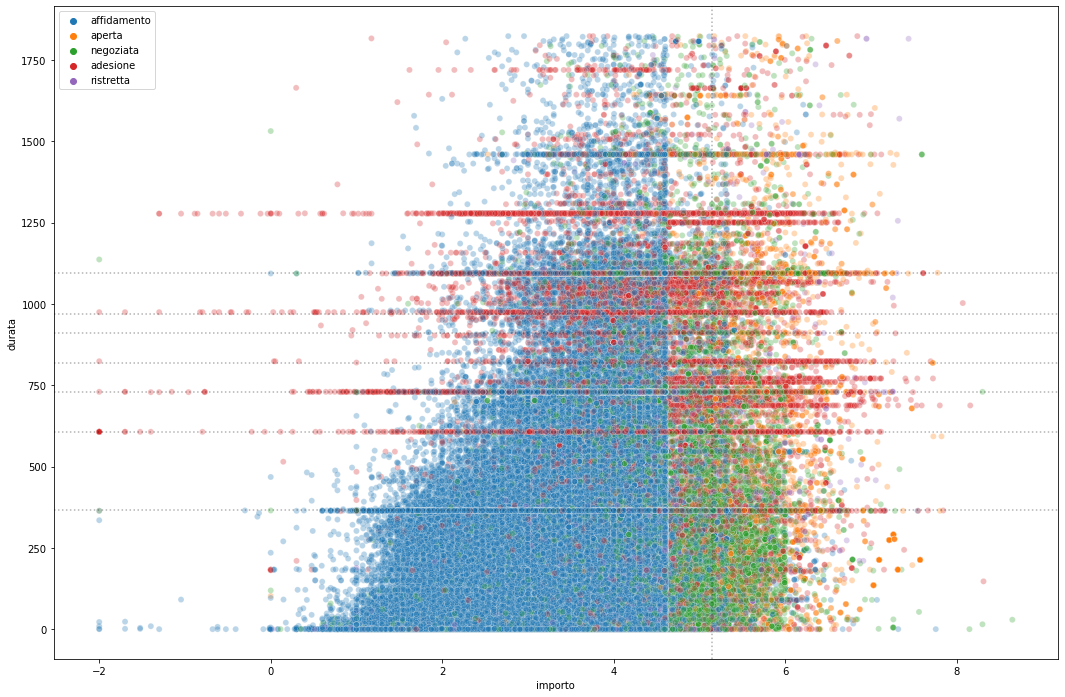

In [15]:
th = 365*5
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df[df.durata.dt.days < th].importo),
    y=df[df.durata.dt.days < th].durata.dt.days,
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(14e4), color='black', linestyle="dotted", alpha=.3)
# plt.axvline(np.log10(10e4), color='black', linestyle="dotted", alpha=.3)
# plt.axvline(np.log10(4e4), color='black', linestyle="dotted", alpha=.3)
plt.axhline(365, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*2, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*3, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365 + 30*8, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*2 + 30*3, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*2 + 30*8, color='black', linestyle="dotted", alpha=.3)
plt.axhline(365*2 + 30*6, color='black', linestyle="dotted", alpha=.3)
# ci sono perodicità annuali
plt.legend(loc='upper left')
plt.show()

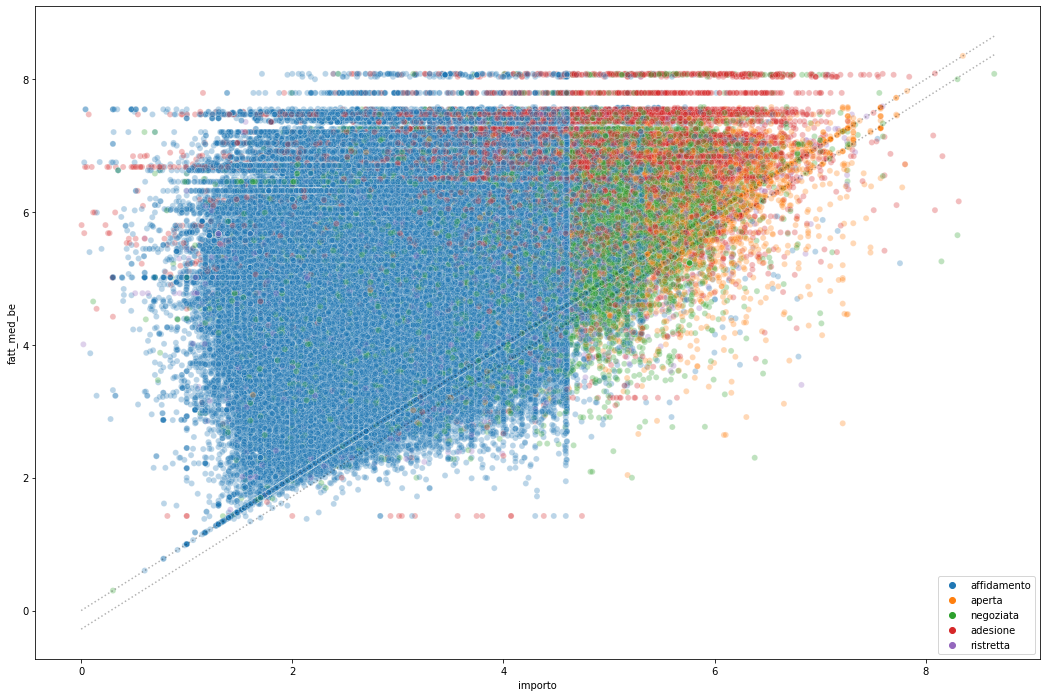

In [20]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0], 
    y=np.log10(df.fatt_med_be)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)

x = np.linspace(0, np.log10(df.importo).max())
# il fatturato dell'azienda coincide con l'importo di un singolo contratto
plt.plot(x, x, color='black', linestyle="dotted", alpha=.3) 
# x - .28 corrisponde a np.log10(df.importo - df.importo * (1 - 10**(-.28))), 
# sono aziende che chiudono un solo contratto all'anno, ma l'importo mediano è inferiore di (1-10^(-.28))
# questo implica che tali aziende hanno applicato un sovrapprezzo a quella stessa fornitura almeno in un anno
plt.plot(x, x - .28, color='black', linestyle="dotted", alpha=.3) 
plt.legend(loc="lower right")
plt.show()

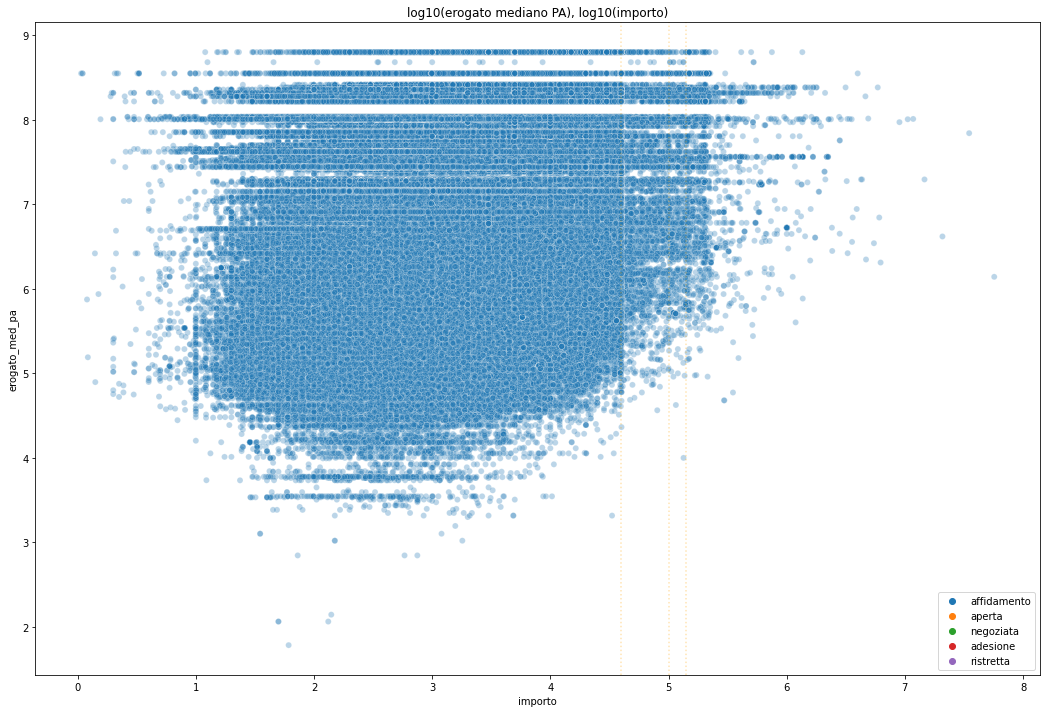

In [21]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0][df.tipo_procedura == "affidamento"], 
    y=np.log10(df.erogato_med_pa)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(14e4), color='orange', linestyle="dotted", alpha=.3)
plt.axvline(np.log10(10e4), color='orange', linestyle="dotted", alpha=.3)
plt.axvline(np.log10(4e4), color='orange', linestyle="dotted", alpha=.3)
plt.legend(loc="lower right")
plt.title("log10(erogato mediano PA), log10(importo)")
plt.show()

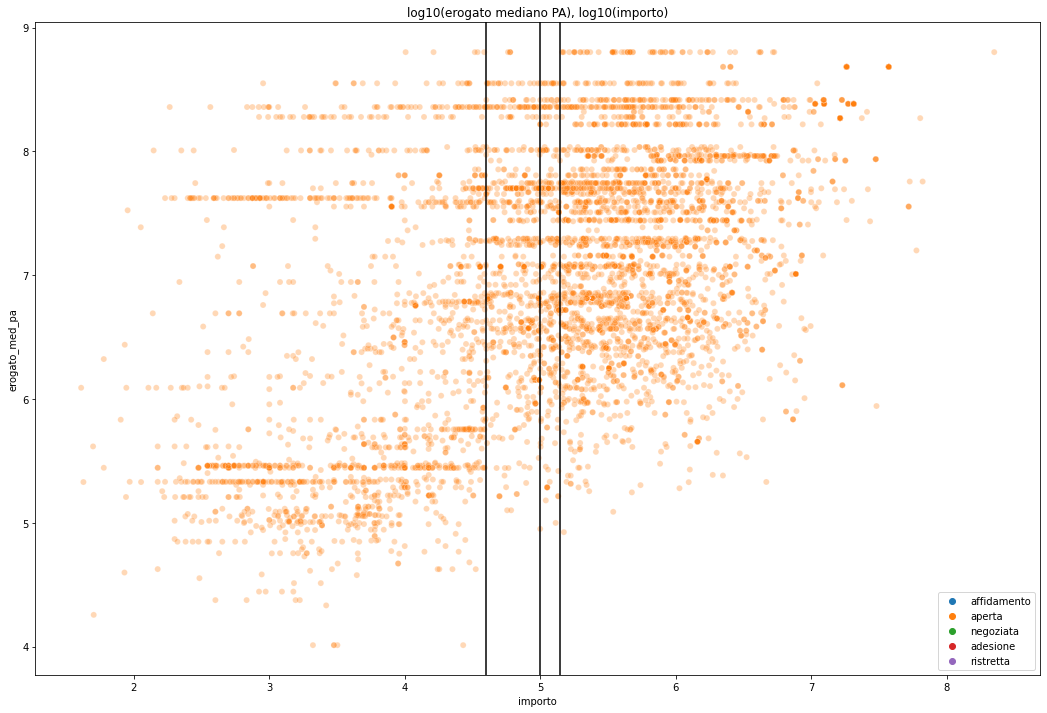

In [22]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0][df.tipo_procedura == "aperta"], 
    y=np.log10(df.erogato_med_pa)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(14e4), color='black')
plt.axvline(np.log10(10e4), color='black')
plt.axvline(np.log10(4e4), color='black')
plt.legend(loc="lower right")
plt.title("log10(erogato mediano PA), log10(importo)")
plt.show()

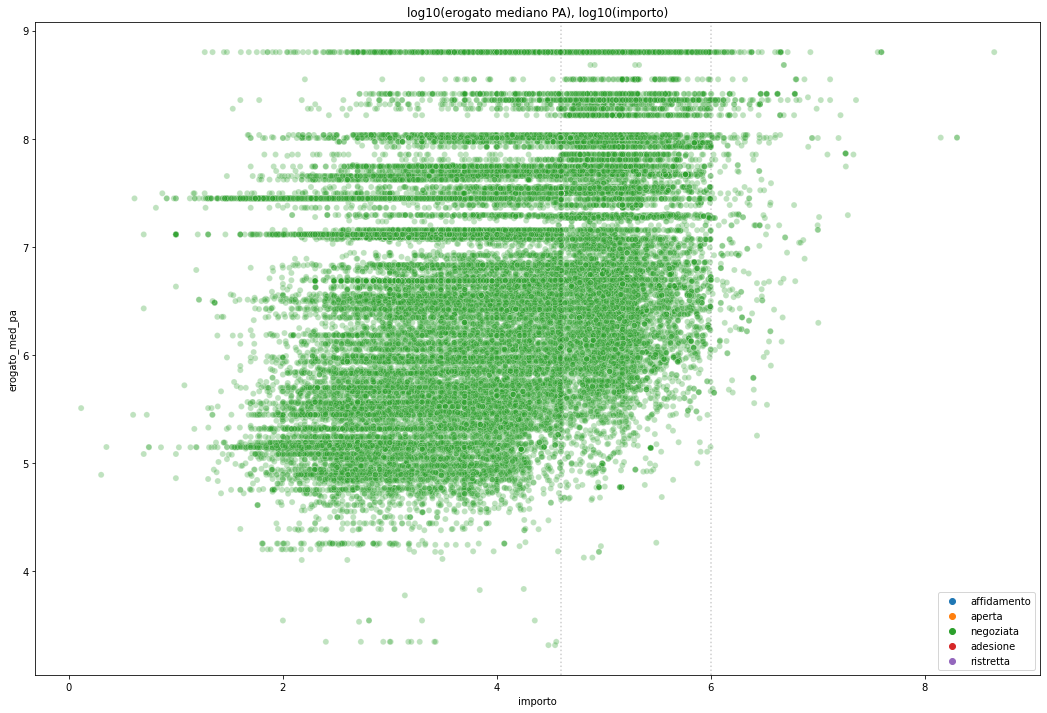

In [23]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0][df.tipo_procedura == "negoziata"], 
    y=np.log10(df.erogato_med_pa)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(4e4), color='black', linestyle="dotted", alpha=.2)
plt.axvline(np.log10(1e6), color='black', linestyle="dotted", alpha=.2)
plt.legend(loc="lower right")
plt.title("log10(erogato mediano PA), log10(importo)")
plt.show()

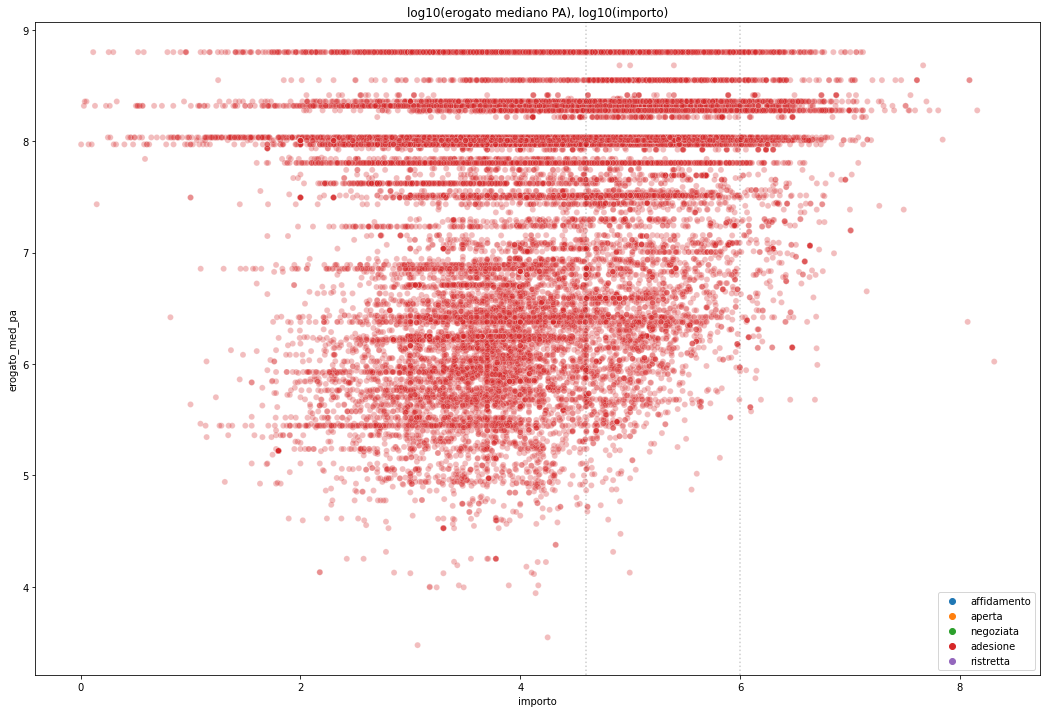

In [24]:
plt.figure(figsize=(6*3, 4*3))
sns.scatterplot(
    x=np.log10(df.importo)[np.log10(df.importo) > 0][df.tipo_procedura == "adesione"], 
    y=np.log10(df.erogato_med_pa)[np.log10(df.importo) > 0],
    alpha=.3, hue=df.tipo_procedura
)
plt.axvline(np.log10(4e4), color='black', linestyle="dotted", alpha=.2)
plt.axvline(np.log10(1e6), color='black', linestyle="dotted", alpha=.2)
plt.legend(loc="lower right")
plt.title("log10(erogato mediano PA), log10(importo)")
plt.show()

In [25]:
# top 5 cpv by occurrences
df.groupby("cpv").size().iloc[df.groupby('cpv').size().argsort()][::-1][:5]

cpv
33    88586
50    53837
30    44448
22    37652
45    32560
dtype: int64

* 33: apparecchiature mediche
* 50: servizi di riparazione e manutenzione
* 30: Macchine per ufficio ed elaboratori elettronici, attrezzature e forniture, esclusi i mobili e i pacchetti software

controllare per contratto mediano per fornitore. 

visualizzare le macro aree cpv

regole: contratti più alti del fatturato mediano e erogato mediano, sono sbagliati (controllare la soglia minima di contratti per azienda). visualizzare gli errati per tipo di procedura e uber_stazione 

# regole per l'eliminazione di outlier
1. contratti più grandi del valore mediano della pa e dell'azienda fornitrice aventi un numero minimo di contratti da valutare
2. affidamenti diretti con durano più di 3 anni.
